In [1]:
#include <lodepng_config_cling.h>
#include <vtkm_config_cling.h>
#include <iostream>
#include <string>
#include <VTKmXeusRender.h>

In [2]:
#include <vtkm/cont/testing/MakeTestDataSet.h>
std::unique_ptr<VTKmXeusRender> renderer;


In [3]:
#pragma cling add_library_path("/opt/adios2/lib")
#pragma cling add_library_path("/usr/lib")
#pragma cling add_library_path("/home/adios/.conda/envs/cling/lib/")
#pragma cling add_include_path("/opt/adios2/include")
#pragma cling add_include_path("/usr/include/mpi")
#pragma cling load("adios2")
#pragma cling load("mpi")
#pragma cling load("mpi_cxx")

#include <adios2.h>
#include <mpi.h>

#include <memory.h>


const int phiMultiplier = 8;
int numNodes, numTris, numPhi, numTimeSteps;

bool running = true;
std::unique_ptr<adios2::IO> fileIO;
std::unique_ptr<adios2::IO> meshIO;

std::unique_ptr<adios2::Engine> fileReader, meshReader;

vtkm::cont::ArrayHandle<vtkm::Id> wedgeConn;
  vtkm::cont::ArrayHandle<vtkm::Vec<double,3>> points;


In [4]:

void initializeReaders(std::string meshName)
{
    fileReader->BeginStep(adios2::StepMode::NextAvailable, 0.0f);

    meshReader = std::make_unique<adios2::Engine>(meshIO->Open(meshName, adios2::Mode::Read));
    
    adios2::Variable<int> nVar = meshIO->InquireVariable<int>("n_n");
    adios2::Variable<int> triVar = meshIO->InquireVariable<int>("n_t");
    adios2::Variable<int> phiVar = fileIO->InquireVariable<int>("nphi");

    if (nVar){
        meshReader->Get(nVar, &numNodes, adios2::Mode::Sync);

    }
    if (triVar)
        meshReader->Get(triVar, &numTris, adios2::Mode::Sync);

    if (phiVar){
        fileReader->Get(phiVar, &numPhi, adios2::Mode::Sync);
        std::cout << "phi: " << numPhi << std::endl;
    }
}

In [5]:
vtkm::cont::DataSet readMesh(
             std::unique_ptr<adios2::IO> &meshIO,
             std::unique_ptr<adios2::Engine> &meshReader)
{
    
    std::cout << "numNodes: " << numNodes << ", numTris " << numTris << ", numPhi " << numPhi << std::endl;
   adios2::Variable<double> coordVar = meshIO->InquireVariable<double>("/coordinates/values");

  std::vector<double> buff;

  //const int newPhi = phiMultiplier * numPhi;
    int newPhi = numPhi;

   meshReader->Get(coordVar, buff, adios2::Mode::Sync);

   auto coords = vtkm::cont::make_ArrayHandle(buff);
  std::vector<int> ibuffc, ibuffn;

  //vtkDataArray *conn = NULL, *nextNode = NULL;
  // meshFile->ReadScalarData("/cell_set[0]/node_connect_list", timestate, &conn);
  // if (!meshFile->ReadScalarData("/nextnode", timestate, &nextNode))
  //     meshFile->ReadScalarData("nextnode", timestate, &nextNode);
  auto nodeConnectorVar = meshIO->InquireVariable<int>("/cell_set[0]/node_connect_list");
  auto nextNodeVar = meshIO->InquireVariable<int>("nextnode");
  if (!nodeConnectorVar || !nextNodeVar)
      return vtkm::cont::DataSet();

  meshReader->Get(nodeConnectorVar, ibuffc,adios2::Mode::Sync);
  auto conn = vtkm::cont::make_ArrayHandle(ibuffc);

  meshReader->Get(nextNodeVar, ibuffn, adios2::Mode::Sync);
  if (ibuffn.size() < 1)
      return vtkm::cont::DataSet();

  auto nextNode = vtkm::cont::make_ArrayHandle(ibuffn);
  //Create the points.

     int numPlanes = numPhi;
    float dPhi =  2.0*M_PI/(float)(numPlanes);

    points.Allocate(numNodes * numPlanes);

    auto pointsPortal = points.GetPortalControl();
    auto coordsPortal = coords.GetPortalConstControl();
    for (int i = 0; i < numPlanes; i++)
    {
        float phi = (float)i * dPhi;
        for (int p = 0; p < numNodes; p++)
        {
            float R = coordsPortal.Get(p*2 +0);
            float Z = coordsPortal.Get(p*2 +1);
            
            vtkm::Vec<float,3> pt;
            pt[0] = R*cos(phi);
            pt[1] = R*sin(phi);
            pt[2] = Z;
            pointsPortal.Set(p+i*numNodes, pt);
        }
    }

    vtkm::Id numCells = (numPlanes)*numTris;

    wedgeConn.Allocate(numCells*6);
    auto wedgeConnPortal = wedgeConn.GetPortalControl();
    auto connPortal = conn.GetPortalConstControl();
    vtkm::Id j = 0;
    for (int i = 0; i < numPlanes-1; i++)
    {
        for (int p = 0; p < numTris*3; p+=3)
        {
            vtkm::Id off = i*numNodes;
            vtkm::Id p0 = connPortal.Get(p+0);
            vtkm::Id p1 = connPortal.Get(p+1);
            vtkm::Id p2 = connPortal.Get(p+2);
            wedgeConnPortal.Set(j+0, p0+off);
            wedgeConnPortal.Set(j+1, p1+off);
            wedgeConnPortal.Set(j+2, p2+off);
            
            off = (i+1) * numNodes;
            vtkm::Id p3 = p0+off;
            vtkm::Id p4 = p1+off;
            vtkm::Id p5 = p2+off;
            wedgeConnPortal.Set(j+3, p3);
            wedgeConnPortal.Set(j+4, p4);
            wedgeConnPortal.Set(j+5, p5);
            j += 6;
        }
    }
    
    int i = numPlanes - 1;
    for (int p = 0; p < numTris*3; p+=3)
        {
            vtkm::Id p0 = connPortal.Get(p+0);
            vtkm::Id p1 = connPortal.Get(p+1);
            vtkm::Id p2 = connPortal.Get(p+2);
        
            vtkm::Id p3 = p0;
            vtkm::Id p4 = p1;
            vtkm::Id p5 = p2;
            vtkm::Id off = i * numNodes;
            wedgeConnPortal.Set(j+0, p0 + off);
            wedgeConnPortal.Set(j+1, p1 + off);
            wedgeConnPortal.Set(j+2, p2 + off);
            wedgeConnPortal.Set(j+3, p3);
            wedgeConnPortal.Set(j+4, p4);
            wedgeConnPortal.Set(j+5, p5);
            j += 6;
        }
    vtkm::cont::DataSetBuilderExplicit builder;
    vtkm::cont::DataSet ds;
    ds = builder.Create(points, vtkm::CellShapeTagWedge(), 6, wedgeConn);

    return ds;

}

In [6]:
vtkm::cont::DataSet 
readValues()
{
    vtkm::cont::DataSetBuilderExplicit builder;
    vtkm::cont::DataSet ds;
    ds = builder.Create(points, vtkm::CellShapeTagWedge(), 6, wedgeConn);

    auto var = fileIO->InquireVariable<double>("dpot");
    std::vector<double> buff;
    fileReader->Get(var, buff,adios2::Mode::Sync);
    auto dpot = vtkm::cont::make_ArrayHandle(buff);

    ds.AddField(vtkm::cont::Field("pointvar", vtkm::cont::Field::Association::POINTS,
                                 buff.size(),
                                 dpot));
    
    return ds;
}

Open /home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.3d.bp
input_line_16 20
0
phi: 4
numNodes: 20694, numTris 41087, numPhi 4


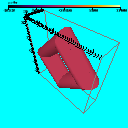

In [ ]:

[](){
auto try_and_err = []() {

    renderer = std::make_unique<VTKmXeusRender>();
    MPI_Init(NULL,NULL);


    adios2::ADIOS adios(MPI_COMM_WORLD);
    adios2::ADIOS mesh(MPI_COMM_WORLD);
    
    int numTimeSteps;
    
    std::string filename("/home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.3d.bp");
    fileIO = std::make_unique<adios2::IO>(adios.DeclareIO("SST"));
    fileIO->SetEngine("SST");
    meshIO = std::make_unique<adios2::IO>(mesh.DeclareIO("BP"));
    meshIO->SetEngine("BP");    
    
    
    fileReader = std::make_unique<adios2::Engine>(fileIO->Open(filename, adios2::Mode::Read));

    std::cout<<"Open "<<filename<<std::endl;
    std::cout<<__FILE__<<" "<<__LINE__<<std::endl;

    const auto variables = fileIO->AvailableVariables();
    std::cout << variables.size() << std::endl;
    
      for (const auto variablePair : variables)
      {
          std::cout << "Name: " << variablePair.first;

          for (const auto &parameter : variablePair.second)
          {
              std::cout << "\t" << parameter.first << ": " << parameter.second
                          << "\n";
          }
      }

//     if (coordVar)
//       return NULL;
    vtkm::cont::DataSet ds;
     initializeReaders("/home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.mesh.bp");
    if (fileReader->BeginStep() == adios2::StepStatus::OK){
        ds = readMesh(meshIO, meshReader);        
        fileReader->EndStep();
    }
    try{
        while(fileReader->BeginStep() ==adios2::StepStatus::OK && running){
            ds = readValues();
            std::string fieldNm("pointvar");
            vtkm::rendering::CanvasRayTracer canvas(128,128);

            renderer->Display(ds, canvas, fieldNm);
            
             fileReader->EndStep();
        }
    
        fileReader->Close();
    
        MPI_Finalize();
    }
    catch(int e){
        fileReader->EndStep();
        fileReader->Close();
        MPI_Finalize();
    }

};
try_and_err();
}();